In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from PIL import Image
import os
import cv2
import random
from PIL import Image, ImageFilter
import os
import numpy as np

# **get unique sizes of images in a folder**

In [ ]:
def get_dim(folder_path):
  unique_dim = set()
  mode = set()

  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    try:
      with Image.open(file_path) as img:
        dim = img.size
        unique_dim.add(dim)

        mode.add(img.mode =="RGB")

    except Exception as e:
      print(e)

  return unique_dim, mode

# **path**

In [ ]:
train_gli_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/glioma_tumor"
train_men_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/meningioma_tumor"
train_no_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/no_tumor"
train_pit_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/pituitary_tumor"


In [ ]:
train_glioma_dim, mode_g = get_dim(train_gli_path)
train_men_dim,mode_m = get_dim(train_men_path)
train_no_dim,mode_n = get_dim(train_no_path)
train_pit_dim,mode_p = get_dim(train_pit_path)

In [ ]:
train_glioma_dim

{(512, 512)}

In [ ]:
train_men_dim

In [ ]:
train_no_dim

In [ ]:
train_men_dim

In [ ]:
train_pit_dim

In [ ]:
min(train_glioma_dim),min(train_men_dim),min(train_no_dim),min(train_pit_dim)

((512, 512), (180, 218), (200, 200), (201, 210))

In [ ]:
max(train_glioma_dim),max(train_men_dim),max(train_no_dim),max(train_pit_dim)

((512, 512), (1275, 1427), (1375, 1446), (1365, 1365))

# **find the image that has specific dim**

In [ ]:
from PIL import Image
import os

def query_images_with_size(folder_path, target_size):
    try:
        # List all files in the specified folder
        files = os.listdir(folder_path)

        for file_name in files:
            # Build the full path to the image file
            file_path = os.path.join(folder_path, file_name)

            # Open the image file
            with Image.open(file_path) as img:
                # Get the dimensions (width and height) of the image
                width, height = img.size

                # Check if dimensions match the target_size
                if (width, height) == target_size:
                    # print(f"Image '{file_name}' has size {target_size}")
                    return file_name

    except Exception as e:
        print(f"Error querying images: {e}")

In [ ]:
query_images_with_size(train_men_path,(212, 238))

'm1(185).jpg'

In [ ]:
query_images_with_size(train_pit_path,(201, 210))

'p (137).jpg'

In [ ]:
def set_to_list(set_val):
# Convert the set to a list for sorting
  data_list = list(set_val)

  # Sort the list based on some criteria, for example, the sum of the tuple elements
  sorted_list = sorted(data_list, key=lambda x: sum(x))

  return sorted_list


In [ ]:
set_to_list(train_men_dim)[:10]

[(180, 218),
 (201, 207),
 (200, 223),
 (202, 223),
 (214, 216),
 (216, 216),
 (209, 225),
 (200, 235),
 (215, 220),
 (200, 236)]

# **Train GLioma**

Taking 526 x 526 images and cropping it to 300 x 300

1. Find the center position(co-ordinates) that divide the image into 4 quadrants
2. From that point, go to the top by subtracting the half of the crop size named `crop_start`  being the **point of interest**
3. Thats the point to be cropped to the origianl `crop_size` so adding 300 pixels to that does the cropping


```
center_coords = np.array((526, 526)) // 2
              = np.array((263, 263))
              = (263, 263)
 So (263, 263) is the central position
```

**crop_size is the size of the region to be cropped to as final**

```
# Crop size
crop_size = (300, 300)

crop_start = (263, 263) - np.array((300, 300)) // 2
           = (263, 263) - (150, 150)
           = (113, 113)

crop_end = (113, 113) + np.array((300, 300))
         = (113, 113) + (300, 300)
         = (413, 413)

```

so cropping the original 526 x 526 to 300 x 300 by retaining the region betwen (113, 113) and (413, 413)

**Purpose: This function (crop_glioma) is designed to crop and process a glioma image represented as a NumPy array.**



> 1.It checks if the input image array has three channels (RGB). If yes, it selects only the first channel (e.g., red channel).

> 2.It calculates the center coordinates of the image and defines a cropping region around it based on the specified or default crop size.


> 3.The function then extracts the cropped region and applies a median filter to enhance the image features.

> 4.The processed cropped image is returned.







In [ ]:
import os
import numpy as np
from scipy.ndimage import median_filter
from PIL import Image

def crop_glioma(image_array, crop_size=300):
    if len(image_array.shape) == 3:
        image_array = image_array[:, :, 0]

    center_coords = np.array(image_array.shape) // 2
    crop_start = center_coords - np.array(crop_size) // 2
    crop_end = crop_start + np.array(crop_size)

    cropped_image = image_array[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1]]
    cropped_image = median_filter(cropped_image, size=3)

    return cropped_image


In [ ]:

def process_folder_glioma(source_path, destination_path):
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Get a list of all files in the source folder
    files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]

    # Iterate over each file and apply the function
    for file in files:
        source_file_path = os.path.join(source_path, file)

        # Load the image
        image = Image.open(source_file_path)

        # Convert the image to a NumPy array
        image_array = np.array(image)

        # Apply center cropping and median filtering
        processed_image = crop_glioma(image_array, crop_size=(300, 300))

        # Save the processed image to the destination folder
        destination_file_path = os.path.join(destination_path, file)
        processed_image_pil = Image.fromarray(processed_image)
        processed_image_pil.save(destination_file_path)


In [ ]:

# Specify the source and destination folder paths
source_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/glioma_tumor"
destination_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/cropped/glioma_tumor_cropped"

# Call the function to process the images
process_folder_glioma(source_folder_path, destination_folder_path)

In [ ]:
!find /content/drive/MyDrive/aaa_tumour_classification/cropped/glioma_tumor_cropped -type f -print0 | xargs -0 ls -l | wc -l

826


In [ ]:
def glioma_comparison():

  source_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/glioma_tumor"
  destination_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/cropped/glioma_tumor_cropped"

  random_number = random.randint(0, 825)
  print(random_number)

  img_name = "/gg ("+str(random_number)+").jpg"

  # Display both images side by side
  plt.figure(figsize=(10, 5))

  # Plot the original image
  plt.subplot(1, 2, 1)
  org = np.array(Image.open(source_folder_path+img_name))
  plt.imshow(org, cmap='gray')  # Assuming the image is grayscale
  plt.title('Original MRI Image')
  plt.colorbar()

  # Plot the cropped image
  plt.subplot(1, 2, 2)
  dest = np.array(Image.open(destination_folder_path+img_name))
  plt.imshow(dest, cmap='gray')  # Assuming the image is grayscale
  plt.title('Cropped MRI Image')
  plt.colorbar()

  plt.show()


792


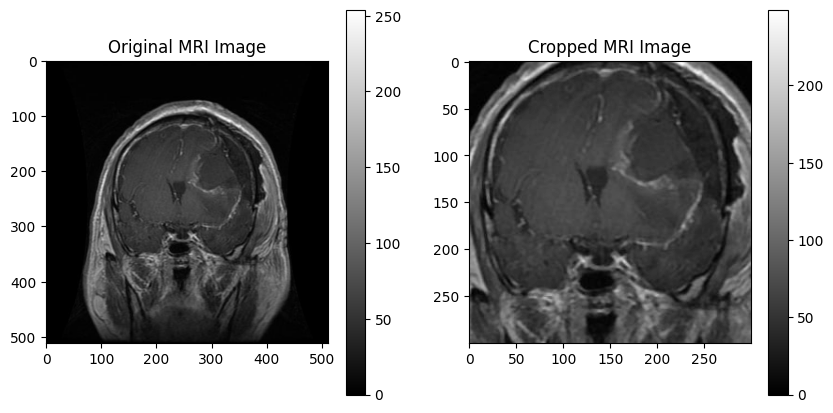

In [ ]:
glioma_comparison()

# **Mengioma Tumor**

In [ ]:
from PIL import Image, ImageFilter
import os
import numpy as np

def crop_meningioma_with_median_filter(image_path, threshold):
    img = Image.open(image_path)
    img_array = np.array(img)

    if len(img_array.shape) == 3:
        img_array = img_array.mean(axis=2)

    black_pixels = img_array < threshold

    non_black_rows, non_black_cols = np.nonzero(~black_pixels)
    top_row, bottom_row = min(non_black_rows), max(non_black_rows)
    left_col, right_col = min(non_black_cols), max(non_black_cols)

    cropped_img_array = img_array[top_row:bottom_row+1, left_col:right_col+1]

    # Apply median filter to the cropped image
    processed_img_array = Image.fromarray(cropped_img_array).filter(ImageFilter.MedianFilter(size=3))

    # Convert the processed image to 'L' mode (grayscale)
    processed_img = processed_img_array.convert('L')

    return processed_img

In [ ]:

def process_folder_meningioma(source_path, destination_path, threshold=20):
    os.makedirs(destination_path, exist_ok=True)

    files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]

    for file in files:
        source_file_path = os.path.join(source_path, file)
        destination_file_path = os.path.join(destination_path, file)

        processed_image = crop_meningioma_with_median_filter(source_file_path, threshold)

        processed_image.save(destination_file_path)

In [ ]:
men_source_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/meningioma_tumor"
men_destination_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/cropped/meningioma_tumor_cropped"


process_folder_meningioma(men_source_folder_path, men_destination_folder_path, threshold=20)

In [ ]:
!find  /content/drive/MyDrive/aaa_tumour_classification/cropped/meningioma_tumor_cropped -type f -print0 | xargs -0 ls -l | wc -l

822


In [ ]:
def meningioma_comparison():

  men_source_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/meningioma_tumor"
  men_destination_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/cropped/meningioma_tumor_cropped"

  import  matplotlib.pyplot as plt
  import random

  random_number = random.randint(1, 200)
  print(random_number)


  # img_name = "/m ("+str(random_number)+").jpg"
  # img_name = "/m1("+str(random_number)+").jpg"
  # img_name = "/m2 ("+str(random_number)+").jpg"
  img_name = "/m3 ("+str(random_number)+").jpg"

  # Display both images side by side
  plt.figure(figsize=(10, 5))

  # Plot the original image
  plt.subplot(1, 2, 1)
  org = np.array(Image.open(men_source_folder_path+img_name))
  plt.imshow(org, cmap='gray')  # Assuming the image is grayscale
  plt.title('Original MRI Image')
  plt.colorbar()

  # Plot the cropped image
  plt.subplot(1, 2, 2)
  dest = np.array(Image.open(men_destination_folder_path+img_name))
  plt.imshow(dest, cmap='gray')  # Assuming the image is grayscale
  plt.title('Cropped MRI Image')
  plt.colorbar()

  plt.show()


27


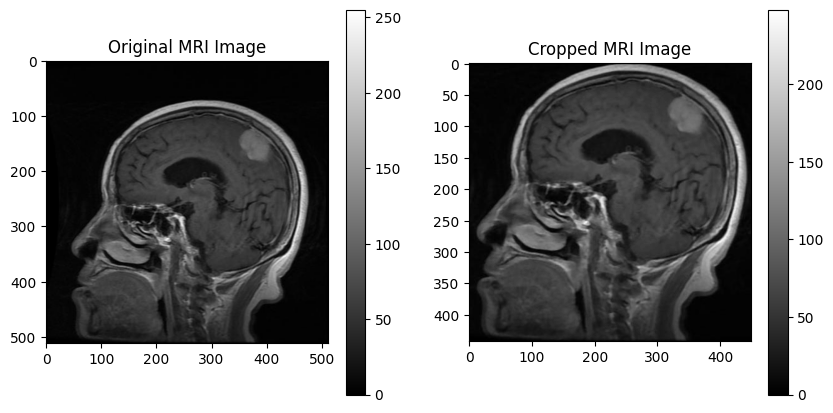

In [ ]:
meningioma_comparison()

# **checking the function**


In [ ]:
def crop_image(image_path, threshold):
    img = Image.open(image_path)
    img_array = np.array(img)

    if len(img_array.shape) == 3:
        img_array = img_array.mean(axis=2)

    black_pixels = img_array < threshold

    non_black_rows, non_black_cols = np.nonzero(~black_pixels)
    top_row, bottom_row = min(non_black_rows), max(non_black_rows)
    left_col, right_col = min(non_black_cols), max(non_black_cols)

    cropped_img_array = img_array[top_row:bottom_row+1, left_col:right_col+1]

    # Apply median filter to the cropped image
    processed_img_array = Image.fromarray(cropped_img_array).filter(ImageFilter.MedianFilter(size=3))

    # Convert the processed image to 'L' mode (grayscale)
    processed_img = processed_img_array.convert('L')

    return processed_img

In [ ]:
def process_folder(source_path, destination_path, threshold=20):
    os.makedirs(destination_path, exist_ok=True)

    files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]

    for file in files:
        source_file_path = os.path.join(source_path, file)
        destination_file_path = os.path.join(destination_path, file)

        processed_image = crop_image(source_file_path, threshold)

        processed_image.save(destination_file_path)

In [ ]:
def comparison(source_folder_path,destination_folder_path,name_format,rand ):

  random_number = random.randint(1, rand)
  print(random_number)

  img_name = name_format + str(random_number)+").jpg"
  print(img_name)

  # Display both images side by side
  plt.figure(figsize=(10, 5))

  # Plot the original image
  plt.subplot(1, 2, 1)
  org = np.array(Image.open(source_folder_path+img_name))
  plt.imshow(org, cmap='gray')  # Assuming the image is grayscale
  plt.title('Original MRI Image')
  plt.colorbar()

  # Plot the cropped image
  plt.subplot(1, 2, 2)
  dest = np.array(Image.open(destination_folder_path+img_name))
  plt.imshow(dest, cmap='gray')  # Assuming the image is grayscale
  plt.title('Cropped MRI Image')
  plt.colorbar()

  plt.show()


In [ ]:
source_folder_path = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/meningioma_tumor"
destination_folder_path = "/content/men"

# Transforming raw into cropped
process_folder(source_folder_path, destination_folder_path, threshold=20)

627
/p (627).jpg


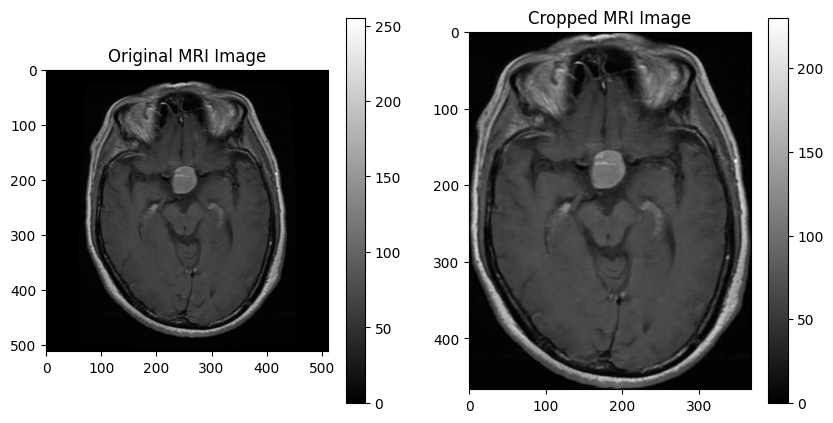

In [ ]:
name_format = '/image('
rand = 100

comparison(source_folder_path,destination_folder_path,name_format,rand)

In [ ]:
name_format = "/gg ("
rand = 800

In [ ]:
# name_format = "/m ("
# name_format = "/m1("
# name_format = "/m2 ("
name_format = "/m3 ("

rand = 200

In [ ]:
name_format = '/image('
rand = 300

In [ ]:
name_format = '/p ('
rand = 800


## **Transforming all folders**


# Original vs Cropped

In [ ]:
org_gli = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/glioma_tumor"
org_men = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/meningioma_tumor"
org_no = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/no_tumor"
org_pit = "/content/drive/MyDrive/aaa_tumour_classification/raw/Training/pituitary_tumor"

cropped_gli = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Training/glioma_tumor"
cropped_men = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Training/meningioma_tumor"
cropped_no = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Training/no_tumor"
cropped_pit = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Training/pituitary_tumor"


In [ ]:
test_org_gli = "/content/drive/MyDrive/aaa_tumour_classification/raw/Testing/glioma_tumor"
test_org_men = "/content/drive/MyDrive/aaa_tumour_classification/raw/Testing/meningioma_tumor"
test_org_no = "/content/drive/MyDrive/aaa_tumour_classification/raw/Testing/no_tumor"
test_org_pit = "/content/drive/MyDrive/aaa_tumour_classification/raw/Testing/pituitary_tumor"

test_cropped_gli = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Testing/glioma_tumor"
test_cropped_men = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Testing/meningioma_tumor"
test_cropped_no = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Testing/no_tumor"
test_cropped_pit = "/content/drive/MyDrive/aaa_tumour_classification/cropped/Testing/pituitary_tumor"

In [ ]:
source_folder_path = org_pit
destination_folder_path = cropped_pit

# Transforming raw into cropped
process_folder(source_folder_path, destination_folder_path, threshold=20)

In [ ]:
source_folder_path = test_org_pit
destination_folder_path = test_cropped_pit
# Transforming raw into cropped
process_folder(source_folder_path, destination_folder_path, threshold=20)

# **Plotting- Train**

690
/gg (690).jpg


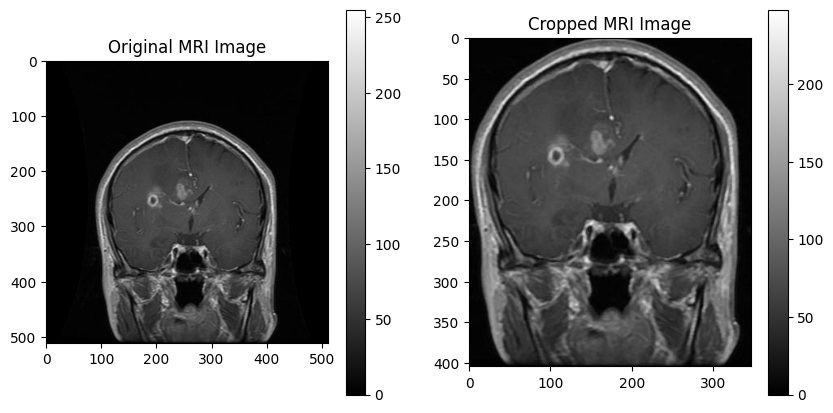

In [ ]:
name_format = "/gg ("
rand = 800
comparison(org_gli,cropped_gli,name_format,rand )

9
/m3 (9).jpg


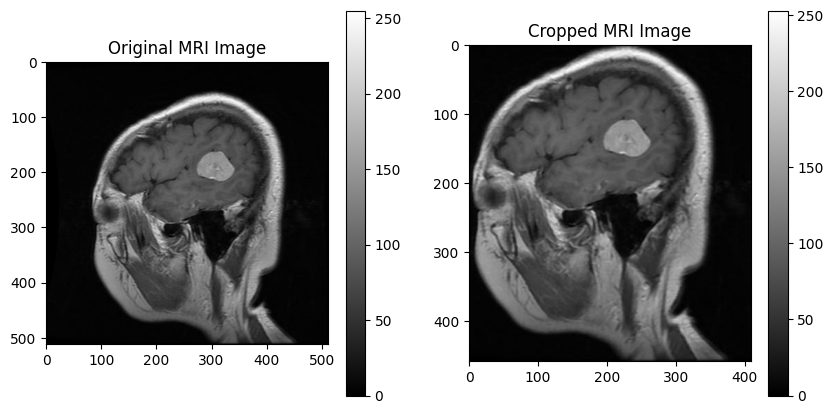

In [ ]:
# name_format = "/m ("
# name_format = "/m1("
# name_format = "/m2 ("
name_format = "/m3 ("

rand = 200
comparison(org_men,cropped_men,name_format,rand )


73
/image(73).jpg


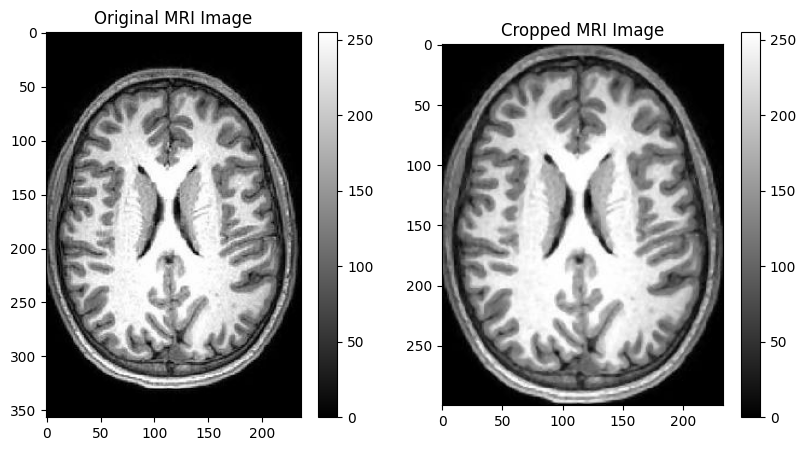

In [ ]:
name_format = '/image('
rand = 100

comparison(org_no,cropped_no,name_format,rand )

601
/p (601).jpg


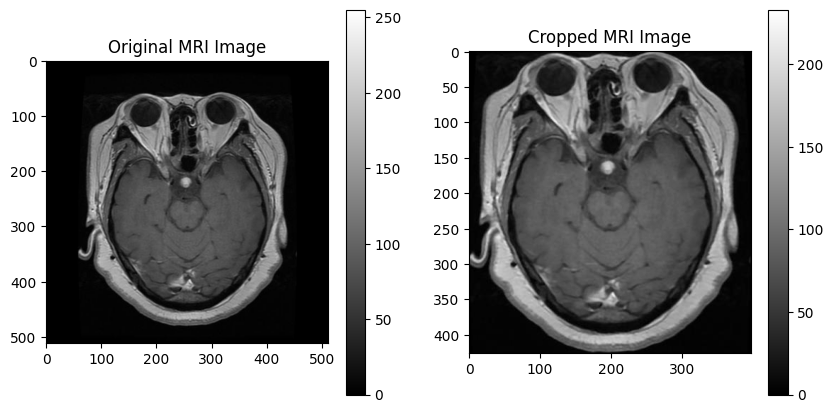

In [ ]:
name_format = '/p ('
rand = 800

comparison(org_pit,cropped_pit,name_format,rand )

# **Plotting-Test**

60
/image(60).jpg


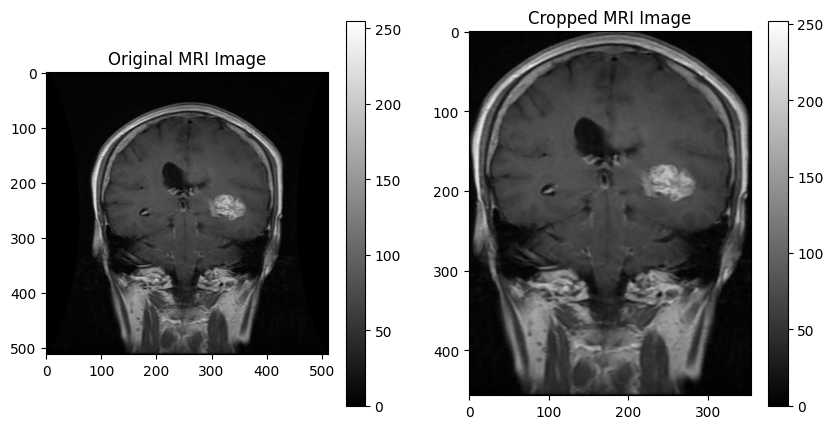

In [ ]:
name_format = "/image("
rand = 100
comparison(test_org_gli,test_cropped_gli,name_format,rand )

92
/image(92).jpg


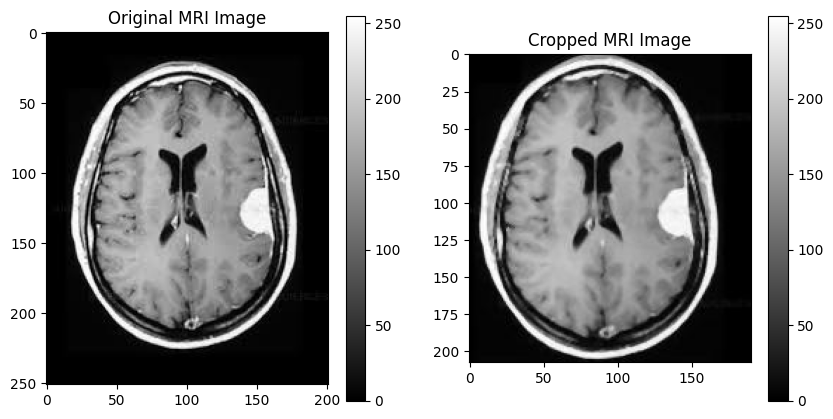

In [ ]:
name_format = "/image("

rand = 100
comparison(test_org_men,test_cropped_men,name_format,rand )


54
/image(54).jpg


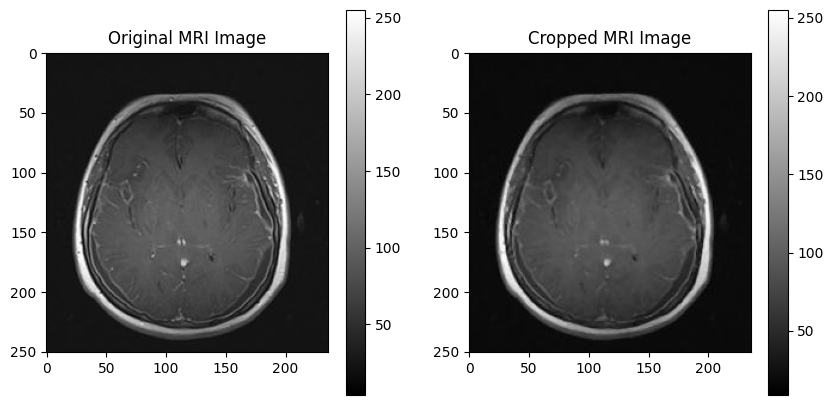

In [ ]:
name_format = '/image('
rand = 100

comparison(test_org_no,test_cropped_no,name_format,rand )

21
/image(21).jpg


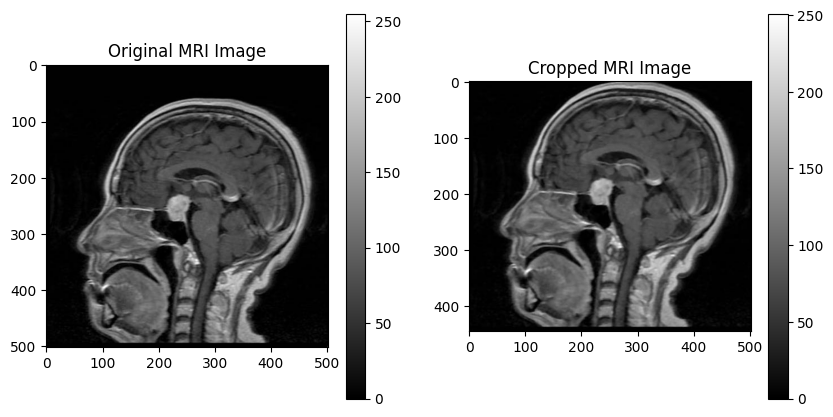

In [ ]:
name_format = '/image('
rand = 22


comparison(test_org_pit,test_cropped_pit,name_format,rand )